In [51]:
import bw2data as bd
import bw2calc as bc
import seaborn as sb
import bw2io as bi
import bw_temporalis as bwt
from bw_temporalis import easy_timedelta_distribution, easy_datetime_distribution, TemporalisLCA, Timeline, TemporalDistribution
from bw_temporalis.lcia import characterize_co2
import numpy as np

In [48]:
bd.projects

Brightway2 projects manager with 12 objects:
	Buildings Insulation
	Temporalis example project
	building
	bw25
	bw25_intro
	bw25_intro2
	bw_temporalis example
	dds-MFA
	default
	parameterLCA
	parametric_LCA
	premise
Use `projects.report()` to get a report on all projects.

In [8]:
# bi.backup.restore_project_directory(
#     fp='brightway2-project-bw25_intro-backup14-November-2024-02-39PM.tar.gz',
#     project_name='building'
# )

Restoring project backup archive - this could take a few minutes...
Restored project: building


'building'

In [20]:
bd.projects.set_current("building")

In [49]:
bd.databases

Databases dictionary with 8 object(s):
	PV 2035
	PV 2050
	PV 2050 - eff
	PV 2050 - eff - lifetime
	biosphere
	carbon fiber
	ecoinvent-3.10-cutoff
	example

In [26]:
bd.Database?

Signature: bd.Database(name: str, backend: str = 'sqlite') -> bw2data.data_store.ProcessedDataStore
Docstring:
A method that returns a database class instance.

Database types are specified in `databases[database_name]['backend']`.
File:      /opt/anaconda3/envs/bw25/lib/python3.11/site-packages/bw2data/database.py
Type:      function

In [28]:
td = easy_timedelta_distribution(
                    start=0,
                    end=11,
                    resolution="M",
                    steps=4, 
                )

In [52]:
bd.Database('temporalis-example').write({
    # CO2 emission
    ('temporalis-example', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "temporalis code": "co2",
    },
    # EPS Production Process
    ('temporalis-example', 'EPS_production'): {
        'exchanges': [
            {
                'amount': 0.8,
                'input': ('temporalis-example', 'CO2'),
                'type': 'biosphere',
                'temporal_distribution': TemporalDistribution(
                    np.array([1], dtype='timedelta64[Y]'),  # Yearly time steps
                    np.array([1])
                ),
            },
        ],
        'name': 'EPS production',
        'type': 'process'
    },
    # EPS End-of-Life Process (Incineration)
    ('temporalis-example', 'EPS_Incineration'): {
        'exchanges': [
            {
                'amount': 0.15,
                'input': ('temporalis-example', 'CO2'),
                'temporal_distribution': TemporalDistribution(
                    np.array([50], dtype='timedelta64[Y]'),  # Emission delayed 50 years
                    np.array([1])
                ),
                'type': 'biosphere'
            },
        ],
        'name': 'EPS Incineration',
        'type': 'process'
    },
    # Functional Unit
    ('temporalis-example', 'Functional Unit - EPS'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('temporalis-example', 'EPS_production'),
                'type': 'technosphere'
            },
            {
                'amount': 1,
                'input': ('temporalis-example', 'EPS_Incineration'),
                'type': 'technosphere'
            },
        ],
        'name': 'Functional Unit - EPS',
        'type': 'process'
    },
})


17:23:41 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 4019.46it/s]

17:23:41 [info     ] Vacuuming database            


In [70]:
for activity in bd.Database('temporalis-example'):
    print(activity)
    for exchange in activity.exchanges():
        print(exchange)


'carbon dioxide' (None, None, None)
'EPS production' (None, None, None)
Exchange: 0.8 None 'carbon dioxide' (None, None, None) to 'EPS production' (None, None, None)>
'EPS Incineration' (None, None, None)
Exchange: 0.15 None 'carbon dioxide' (None, None, None) to 'EPS Incineration' (None, None, None)>
'Functional Unit - EPS' (None, None, None)
Exchange: 1 None 'EPS production' (None, None, None) to 'Functional Unit - EPS' (None, None, None)>
Exchange: 1 None 'EPS Incineration' (None, None, None) to 'Functional Unit - EPS' (None, None, None)>


In [53]:
bd.Method(("GWP", "example")).write([
    (('example', "CO2"), 1),
])

In [54]:
lca = bc.LCA({('example', 'produce-bioethanol'): 1}, ("GWP", "example"))
lca.lci()
lca.lcia()

In [55]:
lca.score

-0.1080000028014183

In [56]:
tlca = TemporalisLCA(lca)

Starting graph traversal
Calculation count: 0


In [57]:
tl = tlca.build_timeline()
df = tl.build_dataframe()

Text(0.5, 0, 'Time (years)')

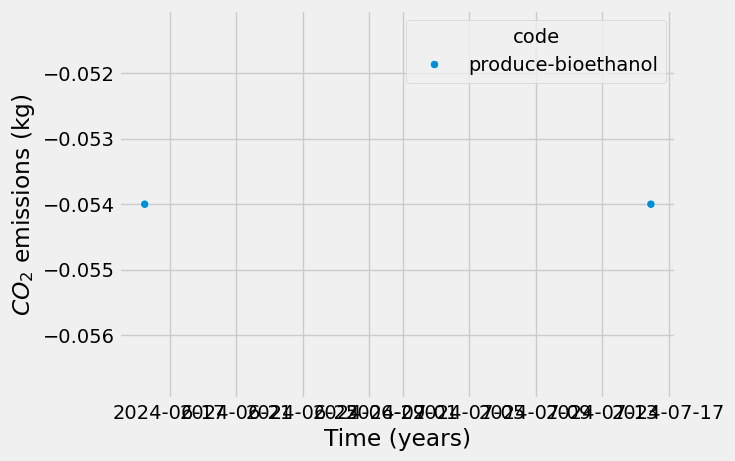

In [58]:
axes = sb.scatterplot(
    x="date", 
    y="amount",
    hue="code",
    data=df.merge(
        bd.Database('example').nodes_to_dataframe().rename(columns={'id': 'activity'}), 
        on='activity'
    )
)
axes.set_ylabel("$CO_{2}$ emissions (kg)")
axes.set_xlabel("Time (years)")